# Background

Previous notebooks showed how Global Differential Privacy (GDP) can be applied to pretect detecting outliers in a dataset. The method was demonstrated using a simple mean calculation as a baseline case.

In most cases, users compute statistics beyond the mean. Here, we will explore how GDP impacts the type 1 error rate and power of a simple t-test.

## What we Expect

In a non-private setting, we expect that the type 1 error rate will be close to the significance level (alpha) and that the power will increase as the effect size increases.

In a private setting, we anticipate that the type 1 error rate may deviate from the nominal alpha level due to the added noise, potentially leading to more false positives. The power may also be affected, possibly requiring larger sample sizes to detect true effects.


# user_pipeline

This function computes the mean and standard deviation of a dataset, performs a one-sample t-test against 0, and returns the results.

A user here is asking to compute this workflow on unseen data.

In [24]:
def user_pipeline(data):
    
    from scipy.stats import ttest_1samp
    import numpy as np

    mean_, std_, t, p = 0, 1, 2, 3
    output = np.full((4,), np.nan)
    output[mean_] = np.mean(data)
    output[std_] = np.std(data, ddof=1)
    output[t], output[p] = ttest_1samp(data, popmean=0)
    return output


# global differential privacy

This function applies GDP to the user_pipeline output by adding Gaussian noise based on the sensitivity of the statistic being computed, itself derived from a leave-one-out analysis.

**Optimization**: The function also returns 'mean', 'std', 't' similar to the user_pipeline output - by computing it inside the dp function we speed up computation.We now also use vectorized leave-one-out computation for significant speedup.

## fast_loo_statistics with jit


The `@jit(nopython=True)` decorator from numba provides Just-In-Time compilation that transforms Python code into optimized machine code:

1. **Compiles to machine code**: Converts Python bytecode to native CPU instructions
2. **Removes Python overhead**: Eliminates interpreter overhead, reference counting, GIL
3. **Type specialization**: Infers types and generates optimized code for specific data types
4. **Loop optimization**: Unrolls loops, vectorizes operations, removes bounds checking
5. **Memory optimization**: Improves cache usage and reduces memory allocations

**Performance gains**: 5-100x speedup depending on the operation. For our vectorized math operations, expect ~5-10x improvement after the initial compilation.

**Trade-off**: First call is slower due to compilation, but all subsequent calls are much faster - perfect for Monte Carlo simulations with repeated function calls.

In [27]:
%pip install numba

from numba import jit
import numpy as np

@jit(nopython=True)
def fast_loo_statistics(data):
    """
    Vectorized computation of leave-one-out statistics for mean, std, and t-statistic.
    This replaces the slow loop-based approach with efficient vectorized operations.
    Now JIT-compiled with numba for additional ~5-10x speedup.
    
    Returns:
        loo_means: array of leave-one-out means
        loo_stds: array of leave-one-out standard deviations  
        loo_t_stats: array of leave-one-out t-statistics
    """
    n = len(data)
    data_sum = np.sum(data)
    data_sq_sum = np.sum(data**2)
    
    # Leave-one-out means: (sum - x_i) / (n-1)
    loo_means = (data_sum - data) / (n - 1)
    
    # Leave-one-out variances: more complex but vectorizable
    # Var = (sum(x^2) - x_i^2) / (n-2) - (n-1) * mean_loo^2 / (n-2)
    loo_vars = ((data_sq_sum - data**2) - (n-1) * loo_means**2) / (n - 2)
    loo_stds = np.sqrt(loo_vars)
    
    # Leave-one-out t-statistics: mean / (std / sqrt(n-1))
    loo_t_stats = loo_means / (loo_stds / np.sqrt(n - 1))
    
    return loo_means, loo_stds, loo_t_stats

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
def batch_dp(data, original_output):
    """
    Apply DP to all statistics at once using vectorized leave-one-out computation.
    This batches the DP computation for mean, std, and t-statistic together.
    
    Args:
        data: input data array
        original_output: output from user_pipeline [mean, std, t, p]
    
    
    Returns:
        noisy_outputs: dict with noisy versions of 'mean', 'std', 't'
        sensitivities: dict with sensitivity values for each statistic
    """
    import numpy as np
    epsilon=1.0

    # Compute all leave-one-out statistics vectorized
    loo_means, loo_stds, loo_t_stats = fast_loo_statistics(data)
    
    # Compute sensitivities for all statistics
    sensitivities = {
        'mean': np.max(np.abs(loo_means - original_output[0])),
        'std': np.max(np.abs(loo_stds - original_output[1])),
        't': np.max(np.abs(loo_t_stats - original_output[2]))
    }
    
    # Add noise to all statistics using the existing noise model
    noisy_outputs = {}
    for stat in ['mean', 'std', 't']:
        if stat == 'mean':
            loo_output = loo_means
            original_val = original_output[0]
        elif stat == 'std':
            loo_output = loo_stds
            original_val = original_output[1]
        elif stat == 't':
            loo_output = loo_t_stats
            original_val = original_output[2]
        
        loo_scale = np.std(loo_output) / epsilon
        while True:
            noise = np.random.normal(loc=0.0, scale=2 * loo_scale)
            if abs(noise) >= sensitivities[stat]:
                break
        
        noisy_outputs[stat] = original_val + noise
    
    return noisy_outputs, sensitivities

# Simulations

We test the error rates and power of the t-test under different conditions.
(1) varying sample sizes
(2) varying effect sizes
(3) directly from the t-test output or recomputing the test from the noisy mean and std.


In [41]:
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import ttest_1samp, t as t_dist
import time

def run_single_mc_iteration(mc, effect_sizes, sample_sizes, alpha=0.05):
    """Run a single Monte Carlo iteration with optimized batch DP computation"""
    iteration_results = []
    
    for effect_size in effect_sizes:
        # Generate master dataset of maximum sample size with effect
        master_data = np.random.normal(effect_size, 1, max(sample_sizes))
        
        for sample_size in sample_sizes:
            # Create subsample
            data = master_data[:sample_size]
            
            # (1) Get original t-test results
            original_output = user_pipeline(data)
            original_p = original_output[3]  # p-value is at index 3
            
            # (2) NEW: Batch DP computation for all statistics at once
            noisy_outputs, sensitivities = batch_dp(data, original_output)
            
            # Extract noisy statistics from the dictionary
            dp_mean = noisy_outputs['mean']
            dp_std = noisy_outputs['std']
            dp_t = noisy_outputs['t']
            
            # Compute p-values from noisy statistics
            dp_p_t = 2 * (1 - t_dist.cdf(np.abs(dp_t), df=sample_size-1))
            dp_t_recomputed = dp_mean / (dp_std / np.sqrt(sample_size))
            dp_p_recomputed = 2 * (1 - t_dist.cdf(np.abs(dp_t_recomputed), df=sample_size-1))
            
            # Store results
            iteration_results.append({
                'mc_iteration': mc,
                'effect_size': effect_size,
                'sample_size': sample_size,
                'original_t': original_output[2],
                'original_p': original_p,
                'original_significant': original_p < alpha,
                'dp_t': dp_t,
                'dp_p_t': dp_p_t,  # from noisy t-statistic
                'dp_significant_t': dp_p_t < alpha,
                'dp_t_recomputed': dp_t_recomputed,
                'dp_p_recomputed': dp_p_recomputed,  # from noisy mean and std
                'dp_significant_recomputed': dp_p_recomputed < alpha
            })
    
    return iteration_results

# Progress tracking callback
def progress_callback(completed_jobs):
    """Callback function to track progress"""
    current_time = time.time()
    elapsed_time = current_time - start_time
    completion_rate = completed_jobs / MC_parallel
    
    if completion_rate > 0:
        estimated_total_time = elapsed_time / completion_rate
        remaining_time = estimated_total_time - elapsed_time
        
        print(f"\rProgress: {completed_jobs}/{MC_parallel} ({completion_rate:.1%}) | "
              f"Elapsed: {elapsed_time:.1f}s | "
              f"ETA: {remaining_time:.1f}s", end='', flush=True)

# Parallel Monte Carlo simulations
MC_parallel = 2000

# varying sample sizes
sample_sizes_parallel = [10, 20, 50, 100, 200]

# varying effect sizes from 0 to 1 by 0.1
effect_sizes_parallel = np.arange(0, 1.1, 0.1)

alpha_parallel = 0.05

print("Starting parallel Monte Carlo simulation...")
print(f"Running {MC_parallel} iterations across {len(sample_sizes_parallel)} sample sizes and {len(effect_sizes_parallel)} effect sizes")
print(f"Total combinations per iteration: {len(sample_sizes_parallel) * len(effect_sizes_parallel)}")
print(f"Using 30 parallel jobs with OPTIMIZED batch DP computation\n")

# Start timing
start_time = time.time()

# Run parallel simulation with progress monitoring
parallel_results = Parallel(n_jobs=30, verbose=10, batch_size=1)(
    delayed(run_single_mc_iteration)(mc, effect_sizes_parallel, sample_sizes_parallel, alpha_parallel) 
    for mc in range(MC_parallel)
)

# Calculate final timing
end_time = time.time()
total_time = end_time - start_time

# Flatten results
results_parallel = [item for sublist in parallel_results for item in sublist]

print(f"\n\nParallel simulation complete!")
print(f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Average time per iteration: {total_time/MC_parallel:.2f} seconds")
print(f"Total results: {len(results_parallel)}")
print(f"Expected results: {MC_parallel * len(sample_sizes_parallel) * len(effect_sizes_parallel)}")

Starting parallel Monte Carlo simulation...
Running 2000 iterations across 5 sample sizes and 11 effect sizes
Total combinations per iteration: 55
Using 30 parallel jobs with OPTIMIZED batch DP computation



[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=30)]: Done  53 tasks      | elapsed:    2.5s
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=30)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=30)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=30)]: Done  53 tasks      | elapsed:    2.5s
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=30)]: Done  85 tasks      | elapsed:    2.6s
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed:    2.7s
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=30)]: Done  85 tasks      | elapsed:  



Parallel simulation complete!
Total time: 138.3 seconds (2.3 minutes)
Average time per iteration: 0.07 seconds
Total results: 110000
Expected results: 110000


[Parallel(n_jobs=30)]: Done 2000 out of 2000 | elapsed:  2.3min finished


# Type 1 Error Analysis

Analyze the type 1 error rates for different methods across sample sizes. Type 1 error occurs when we incorrectly reject the null hypothesis (effect size = 0).

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results_parallel)

# Filter for effect size = 0 (null hypothesis true)
type1_data = df_results[df_results['effect_size'] == 0.0].copy()

# Calculate type 1 error rates for each sample size
type1_summary = []

for sample_size in sample_sizes_parallel:
    subset = type1_data[type1_data['sample_size'] == sample_size]
    
    # Calculate error rates (proportion of significant results)
    error_rate_original = subset['original_significant'].mean()
    error_rate_dp_t = subset['dp_significant_t'].mean()
    error_rate_dp_recomputed = subset['dp_significant_recomputed'].mean()
    
    type1_summary.append({
        'sample_size': sample_size,
        'original_error_rate': error_rate_original,
        'dp_t_error_rate': error_rate_dp_t,
        'dp_recomputed_error_rate': error_rate_dp_recomputed,
        'n_simulations': len(subset)
    })

type1_df = pd.DataFrame(type1_summary)
print("Type 1 Error Rates Summary:")
print(type1_df)

Type 1 Error Rates Summary:
   sample_size  original_error_rate  dp_t_error_rate  \
0           10                0.050           0.1675   
1           20                0.054           0.1200   
2           50                0.052           0.0910   
3          100                0.042           0.0600   
4          200                0.049           0.0635   

   dp_recomputed_error_rate  n_simulations  
0                    0.1765           2000  
1                    0.1275           2000  
2                    0.0935           2000  
3                    0.0615           2000  
4                    0.0540           2000  


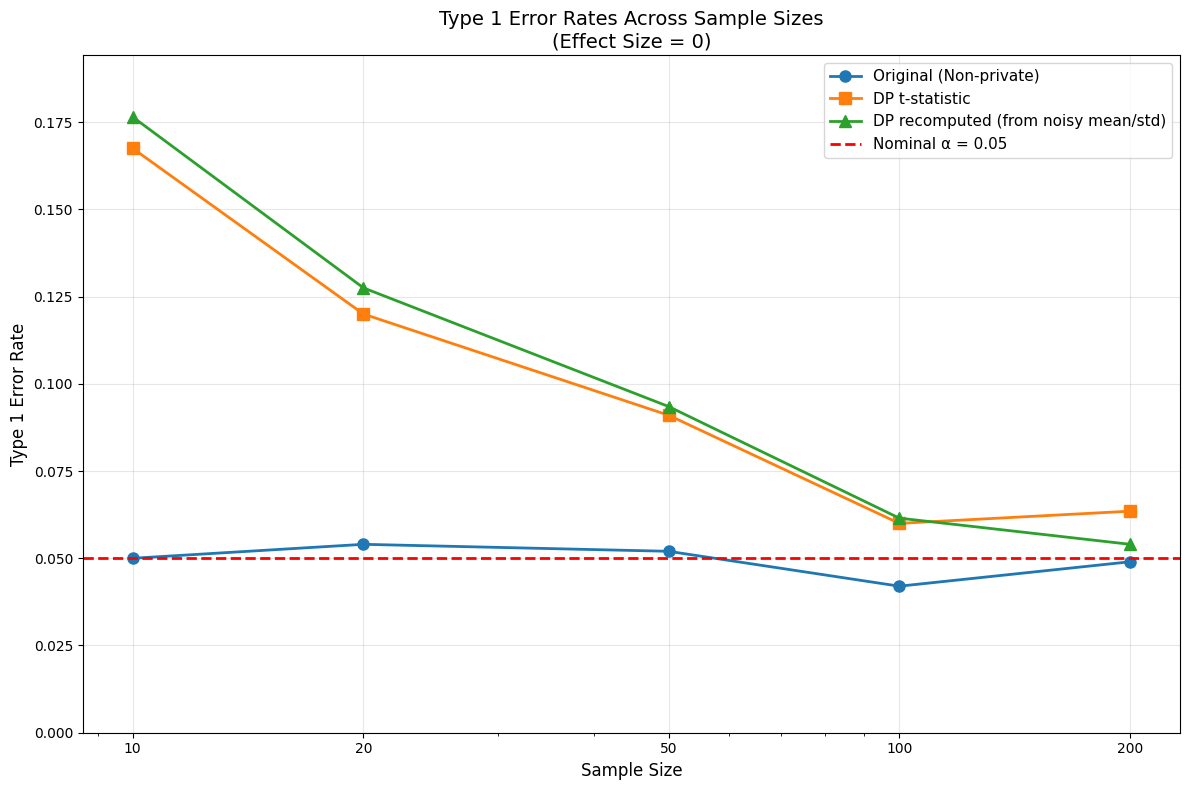


Expected Type 1 error rate: 0.05
Number of MC iterations per sample size: 2000


In [43]:
# Plot Type 1 Error Rates
plt.figure(figsize=(12, 8))

# Plot the three methods
plt.plot(type1_df['sample_size'], type1_df['original_error_rate'], 
         'o-', label='Original (Non-private)', linewidth=2, markersize=8)
plt.plot(type1_df['sample_size'], type1_df['dp_t_error_rate'], 
         's-', label='DP t-statistic', linewidth=2, markersize=8)
plt.plot(type1_df['sample_size'], type1_df['dp_recomputed_error_rate'], 
         '^-', label='DP recomputed (from noisy mean/std)', linewidth=2, markersize=8)

# Add reference line for nominal alpha level
plt.axhline(y=alpha_parallel, color='red', linestyle='--', 
           label=f'Nominal α = {alpha_parallel}', linewidth=2)

# Formatting
plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Type 1 Error Rate', fontsize=12)
plt.title('Type 1 Error Rates Across Sample Sizes\n(Effect Size = 0)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, max(0.15, type1_df[['original_error_rate', 'dp_t_error_rate', 'dp_recomputed_error_rate']].max().max() * 1.1))

# Log scale for x-axis might be helpful
plt.xscale('log')
plt.xticks(sample_sizes_parallel, sample_sizes_parallel)

plt.tight_layout()
plt.show()

print(f"\nExpected Type 1 error rate: {alpha_parallel}")
print(f"Number of MC iterations per sample size: {MC_parallel}")

# Power Analysis

Analyze the statistical power for different methods across sample sizes and effect sizes. Power is the probability of correctly rejecting the null hypothesis when the alternative hypothesis is true (effect size > 0).

In [44]:
# Filter for effect sizes > 0 (alternative hypothesis true)
power_data = df_results[df_results['effect_size'] > 0.0].copy()

# Calculate power rates for each combination of effect size and sample size
power_summary = []

for effect_size in effect_sizes_parallel[1:]:  # Skip effect size 0
    for sample_size in sample_sizes_parallel:
        subset = power_data[(power_data['effect_size'] == effect_size) & 
                           (power_data['sample_size'] == sample_size)]
        
        # Calculate power rates (proportion of significant results)
        power_original = subset['original_significant'].mean()
        power_dp_t = subset['dp_significant_t'].mean()
        power_dp_recomputed = subset['dp_significant_recomputed'].mean()
        
        power_summary.append({
            'effect_size': effect_size,
            'sample_size': sample_size,
            'original_power': power_original,
            'dp_t_power': power_dp_t,
            'dp_recomputed_power': power_dp_recomputed,
            'n_simulations': len(subset)
        })

power_df = pd.DataFrame(power_summary)
print("Power Summary (first 10 rows):")
print(power_df.head(10))
print(f"\nTotal combinations: {len(power_df)}")

Power Summary (first 10 rows):
   effect_size  sample_size  original_power  dp_t_power  dp_recomputed_power  \
0          0.1           10          0.0570      0.1835               0.1845   
1          0.1           20          0.0755      0.1410               0.1475   
2          0.1           50          0.0975      0.1445               0.1370   
3          0.1          100          0.1620      0.1825               0.1885   
4          0.1          200          0.2840      0.2885               0.2880   
5          0.2           10          0.0870      0.2305               0.2120   
6          0.2           20          0.1355      0.2170               0.2145   
7          0.2           50          0.2895      0.2985               0.3090   
8          0.2          100          0.4915      0.4890               0.4995   
9          0.2          200          0.7935      0.7885               0.7945   

   n_simulations  
0           2000  
1           2000  
2           2000  
3           

ValueError: 'yerr' must not contain negative values

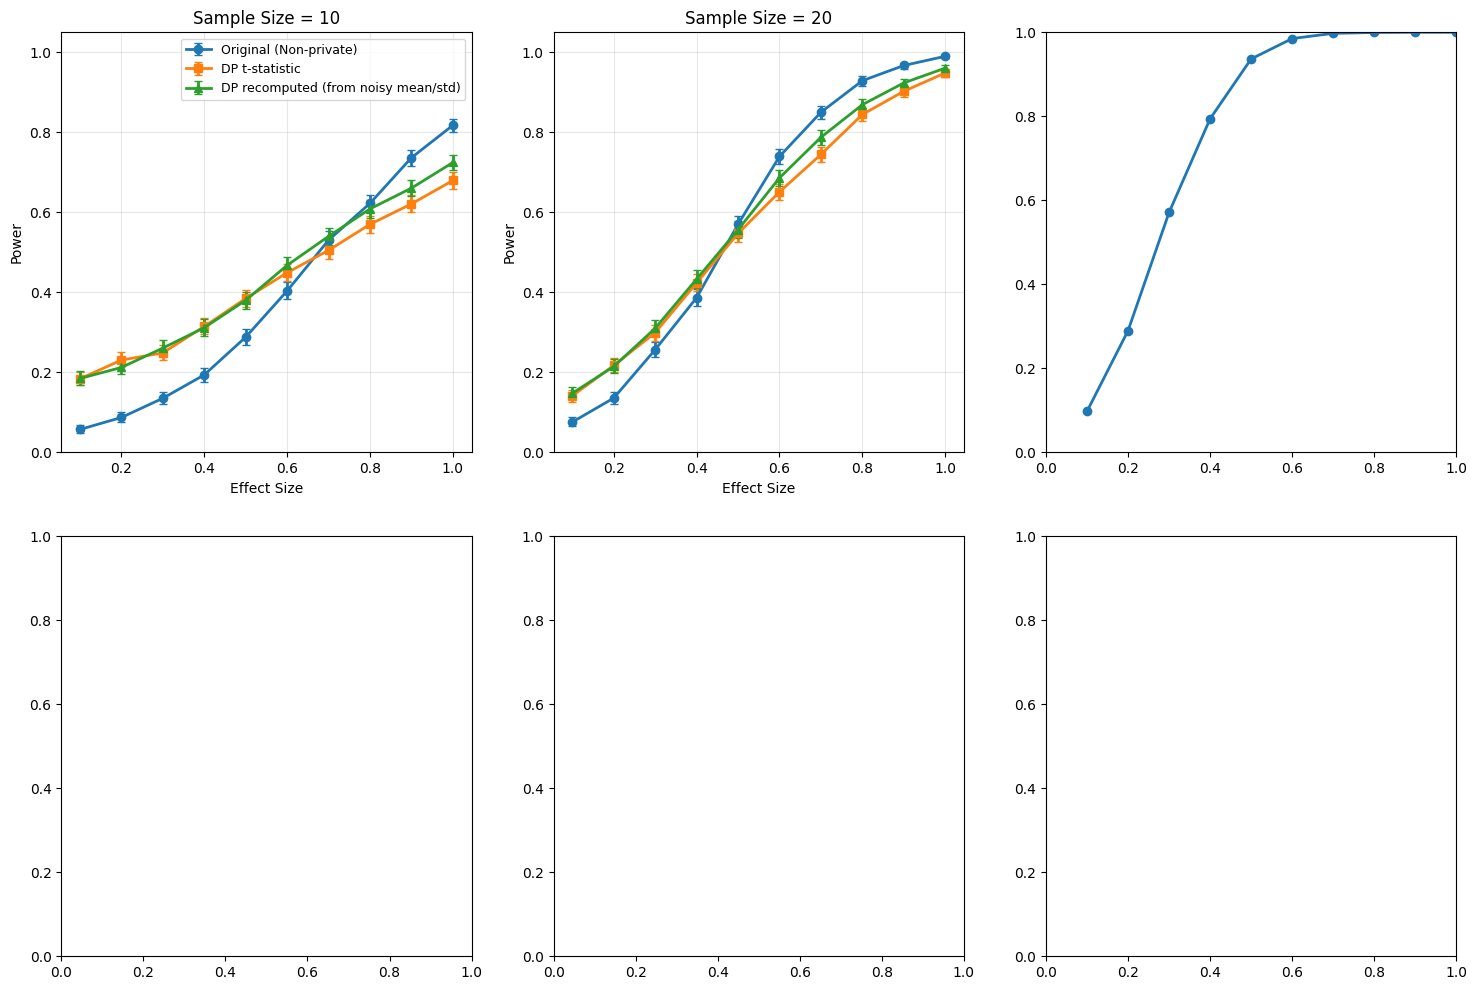

In [ ]:
import scipy.stats as stats

def binomial_confidence_interval(successes, trials, confidence=0.95):
    """
    Calculate binomial confidence interval using Wilson score interval.
    More robust than normal approximation, especially for small samples.
    """
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    
    p = successes / trials
    n = trials
    
    # Wilson score interval
    denominator = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denominator
    half_width = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denominator
    
    lower = centre - half_width
    upper = centre + half_width
    
    return np.clip([lower, upper], 0, 1)  # Ensure bounds are [0,1]

# Create power curves plot with confidence intervals
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Create a plot for each sample size
for i, sample_size in enumerate(sample_sizes_parallel):
    ax = axes[i]
    
    # Filter data for this sample size
    subset = power_df[power_df['sample_size'] == sample_size]
    
    # Calculate confidence intervals for each method
    original_cis = []
    dp_t_cis = []
    dp_recomputed_cis = []
    
    for _, row in subset.iterrows():
        n_sims = row['n_simulations']
        
        # Original power CI
        orig_successes = int(row['original_power'] * n_sims)
        orig_ci = binomial_confidence_interval(orig_successes, n_sims)
        original_cis.append(orig_ci)
        
        # DP t-statistic power CI
        dp_t_successes = int(row['dp_t_power'] * n_sims)
        dp_t_ci = binomial_confidence_interval(dp_t_successes, n_sims)
        dp_t_cis.append(dp_t_ci)
        
        # DP recomputed power CI
        dp_recomp_successes = int(row['dp_recomputed_power'] * n_sims)
        dp_recomp_ci = binomial_confidence_interval(dp_recomp_successes, n_sims)
        dp_recomputed_cis.append(dp_recomp_ci)
    
    # Convert to numpy arrays for easier plotting
    original_cis = np.array(original_cis)
    dp_t_cis = np.array(dp_t_cis)
    dp_recomputed_cis = np.array(dp_recomputed_cis)
    
    # Calculate error bar distances (ensure non-negative)
    orig_lower_err = np.maximum(0, subset['original_power'].values - original_cis[:, 0])
    orig_upper_err = np.maximum(0, original_cis[:, 1] - subset['original_power'].values)
    
    dp_t_lower_err = np.maximum(0, subset['dp_t_power'].values - dp_t_cis[:, 0])
    dp_t_upper_err = np.maximum(0, dp_t_cis[:, 1] - subset['dp_t_power'].values)
    
    dp_recomp_lower_err = np.maximum(0, subset['dp_recomputed_power'].values - dp_recomputed_cis[:, 0])
    dp_recomp_upper_err = np.maximum(0, dp_recomputed_cis[:, 1] - subset['dp_recomputed_power'].values)
    
    # Plot power curves with error bars
    ax.errorbar(subset['effect_size'], subset['original_power'], 
                yerr=[orig_lower_err, orig_upper_err], 
                fmt='o-', label='Original (Non-private)', linewidth=2, markersize=6,
                capsize=3, capthick=1)
    
    ax.errorbar(subset['effect_size'], subset['dp_t_power'], 
                yerr=[dp_t_lower_err, dp_t_upper_err], 
                fmt='s-', label='DP t-statistic', linewidth=2, markersize=6,
                capsize=3, capthick=1)
    
    ax.errorbar(subset['effect_size'], subset['dp_recomputed_power'], 
                yerr=[dp_recomp_lower_err, dp_recomp_upper_err], 
                fmt='^-', label='DP recomputed (from noisy mean/std)', linewidth=2, markersize=6,
                capsize=3, capthick=1)
    
    # Formatting
    ax.set_xlabel('Effect Size', fontsize=10)
    ax.set_ylabel('Power', fontsize=10)
    ax.set_title(f'Sample Size = {sample_size}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    if i == 0:
        ax.legend(fontsize=9)

plt.suptitle('Statistical Power Across Effect Sizes and Sample Sizes\n(with 95% Confidence Intervals)', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Number of MC iterations per combination: {MC_parallel}")
print("Error bars show 95% binomial confidence intervals using Wilson score method")

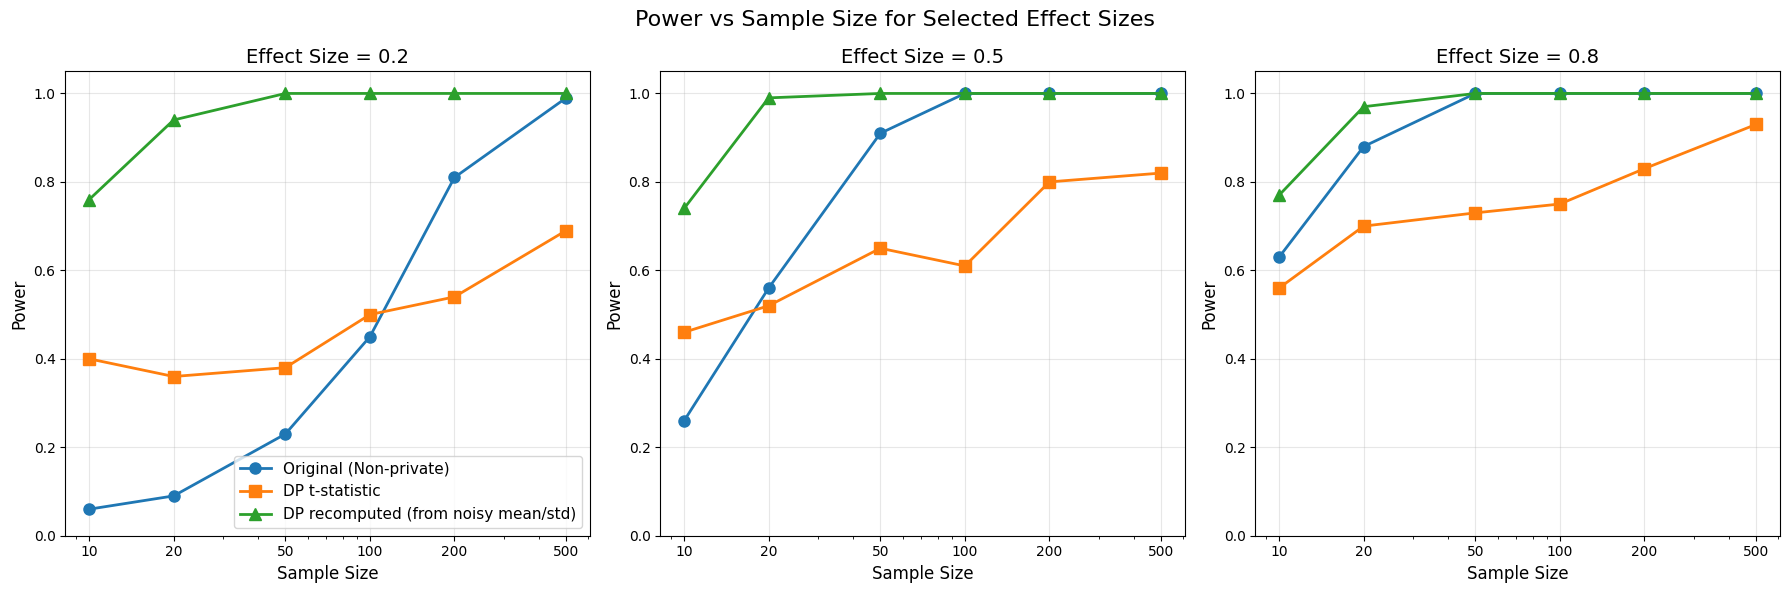

In [19]:
# Power comparison at specific effect sizes
selected_effects = [0.2, 0.5, 0.8]  # Small, medium, large effect sizes

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, effect_size in enumerate(selected_effects):
    ax = axes[i]
    
    # Filter data for this effect size
    subset = power_df[power_df['effect_size'] == effect_size]
    
    # Plot power vs sample size for each method
    ax.plot(subset['sample_size'], subset['original_power'], 
            'o-', label='Original (Non-private)', linewidth=2, markersize=8)
    ax.plot(subset['sample_size'], subset['dp_t_power'], 
            's-', label='DP t-statistic', linewidth=2, markersize=8)
    ax.plot(subset['sample_size'], subset['dp_recomputed_power'], 
            '^-', label='DP recomputed (from noisy mean/std)', linewidth=2, markersize=8)
    
    # Formatting
    ax.set_xlabel('Sample Size', fontsize=12)
    ax.set_ylabel('Power', fontsize=12)
    ax.set_title(f'Effect Size = {effect_size}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    ax.set_xscale('log')
    ax.set_xticks(sample_sizes_parallel)
    ax.set_xticklabels(sample_sizes_parallel)
    
    if i == 0:
        ax.legend(fontsize=11)

plt.suptitle('Power vs Sample Size for Selected Effect Sizes', fontsize=16)
plt.tight_layout()
plt.show()